# Paper details:
Title: Translating Embeddings for Modeling Multi-relational Data  
Authors: Antoine Bordes, Nicolas Usunier, Alberto Garcia-Durán  
Venue: NIPS-2013  

# Paper Q&A
**0. What is the task and it"s real world significance?**  
Link Prediction is a task in graph and network analysis where the goal is to predict missing or future connections between nodes in a network. Given a partially observed network, the goal of link prediction is to infer which links are most likely to be added or missing based on the observed connections and the structure of the network. Examples of link prediction include predicting friendship links among users in a social network, predicting co-authorship links in a citation network, and predicting interactions between genes and proteins in a biological network.  

**1. How do you ensure that entities and relationship gets the embeddings that are close to reality given the data?**  
TransE, an energy-based model for learning low-dimensional embeddings of entities. In TransE, relationships
are represented as translations in the embedding space: if (h, l, t) holds, then the embedding of the
tail entity t should be close to the embedding of the head entity h plus some vector that depends
on the relationship l. Our approach relies on a reduced set of parameters as it learns only one
low-dimensional vector for each entity and each relationship.  

**2. What are the previous inspirations that lead to this framing of transE.**  
The main motivation behind our translation-based parameterization is that hierarchical relationships
are extremely common in KBs and translations are the natural transformations for representing them. Another, secondary, motivation comes from the recent work of word2vec, in which the authors learn word embeddings from free text, and some 1-to-1 relationships between entities of different types, such “capital of” between countries and cities, are (coincidentally rather than willingly) represented by the model as translations in the embedding space. This suggests that there may exist embedding spaces in which 1-to-1 relationships between entities of different types may, as well, be represented by translations.

**3. What are the emperically found hyper parameters that produced best results?**  
For experiments with TransE, we selected the learning rate λ for the stochastic
gradient descent among {0.001, 0.01, 0.1}, the margin γ among {1, 2, 10} and the latent dimension
k among {20, 50} on the validation set of each data set. The dissimilarity measure d was set either
to the L1 or L2 distance according to validation performance as well. Optimal configurations were:
k = 20, λ = 0.01, γ = 2, and d = L1 on Wordnet; k = 50, λ = 0.01, γ = 1, and d = L 1 on FB15k; k = 50, λ = 0.01, γ = 1, and d = L2 on FB1M. For all data sets, training time was limited to at most 1, 000 epochs over the training set.  
**4. What is the loss function selected. Why not anything else?**  
For training for each triplet (head, relation, tree) a corrupted triplet ids generated (head', relation, tail') by replacing either head or tail but not both from the original triplet. Loss function is designed in such a way the it favours d(head+relation, tail) more than  d(head'+relation, tail') where d can be any distance measure like L1-norm, or L2-norm. So choice of loss function is Margin Ranking loss.  
**5. How do you evaluate performance?**   
hits@10, mean rank

## import necessary modules

In [12]:
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.3 MB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 505 kB 77.3 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 75.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Implementation

In [1]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA is available! You have a GPU!")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is not available. Running on CPU.


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.utils import shuffle
from tqdm.auto import tqdm



In [2]:
# if you are running a kaggle notebook
if os.environ.get('KAGGLE_URL_BASE',''):
    DATA_DIR = "/kaggle/input/fb15k-237"
    OUTPUT_DIR = "/kaggle/output"
else:
    os.makedirs("input/kg_embeddings", exist_ok=True)
    os.makedirs("output/kg_embeddings", exist_ok=True)
    # # download files from kaggle
    #!kaggle datasets download -d latebloomer/fb15k-237
    #!unzip -d input/kg_embeddings fb15k-237.zip
    DATA_DIR = "input/kg_embeddings"
    OUTPUT_DIR = "output/kg_embeddings"

In [3]:
# This Python   3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fb15k-237/valid.txt
/kaggle/input/fb15k-237/test.txt
/kaggle/input/fb15k-237/train.txt


In [4]:
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

device = get_device()
print(f"device: {device}")
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


device: cuda


## Data processing

In [2]:
# data exploration
import pandas as pd

train_df = pd.read_csv(f"/Users/fs-mk-mb-022/Downloads/archive/train.txt", delimiter="\t", names=["head", "relation", "tail"])
test_df = pd.read_csv(f"/Users/fs-mk-mb-022/Downloads/archive/test.txt", delimiter="\t", names=["head", "relation", "tail"])
val_df = pd.read_csv(f"/Users/fs-mk-mb-022/Downloads/archive/valid.txt", delimiter="\t", names=["head", "relation", "tail"])


In [14]:
train_df

,head,relation,tail
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8
...,...,...,...
272110,/m/016mhd,/film/film/release_date_s./film/film_regional_...,/m/029j_
272111,/m/01g888,/music/genre/artists,/m/01vv126
272112,/m/0djvzd,/soccer/football_player/current_team./sports/s...,/m/02b16p
272113,/m/0gmblvq,/award/award_winning_work/awards_won./award/aw...,/m/07kjk7c


In [16]:
%pip install pykeen

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 703 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 174 kB 32.5 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 20.6 MB/s eta 0:00:01
     |████████████████████████████████| 380 kB 37.0 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 23.6 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 22.0 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 76.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 73.1 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 22.9 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 29.9 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 73.7 MB/s eta 0:00:01
     |████████████████████████████████| 120 kB 61.1 MB/s eta 0:00:01
     |██████████████████████████

In [5]:
from pykeen.triples import TriplesFactory

# Assuming your dataframe has columns 'subject', 'predicate', 'object'
triples_factory = TriplesFactory.from_labeled_triples(
    triples=val_df[['head', 'relation', 'tail']].values,
)

#training = triples_factory
validation = triples_factory
#testing = triples_factory

d=validation
id_to_entity={v: k for k, v in d.entity_to_id.items()}
id_to_relation={v: k for k, v in d.relation_to_id.items()}

# Display the first few triples
triples_factory.triples

Reconstructing all label-based triples. This is expensive and rarely needed.


array([['/m/010016', '/common/topic/webpage./common/webpage/category',
        '/m/08mbj5d'],
       ['/m/0105y2', '/common/topic/webpage./common/webpage/category',
        '/m/08mbj5d'],
       ['/m/0108xl',
        '/location/hud_foreclosure_area/estimated_number_of_mortgages./measurement_unit/dated_integer/source',
        '/m/0jbk9'],
       ...,
       ['/m/0zm1',
        '/people/person/spouse_s./people/marriage/type_of_union',
        '/m/04ztj'],
       ['/m/0zz6w', '/common/topic/webpage./common/webpage/category',
        '/m/08mbj5d'],
       ['/m/0zz6w', '/location/hud_county_place/place', '/m/0zz6w']],
      dtype='<U146')

In [19]:

from pykeen.pipeline import pipeline

before_result = pipeline(
    model='TransE',
    loss="softplus",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=3),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=100, use_tqdm_batch=False),  # Increase the number of epochs
)


NameError: name 'testing' is not defined

In [6]:
# Import necessary libraries
from pykeen.pipeline import pipeline
from pykeen.models import TransE
import optuna

# Define your training, testing, and validation data (assuming you have these prepared)

def get_metrics(result):
    """
    Extract multiple metrics from the evaluation result.
    """
    metrics = {
        'hits@1': result.get_metric('hits@1'),
        'hits@3': result.get_metric('hits@3'),
        'hits@5': result.get_metric('hits@5'),
        'meanreciprocalrank': result.get_metric('meanreciprocalrank')
    }
    return metrics

def objective(trial: optuna.Trial) -> float:
    # Define model-specific parameters to be optimized
    model_kwargs = {
        'embedding_dim': trial.suggest_categorical('embedding_dim', [50, 100, 200]),
        'random_seed': 42  # You can fix the random seed if needed
    }

    # Define optimizer parameters to be optimized
    optimizer_kwargs = {
        'lr': trial.suggest_loguniform('lr', 1e-5, 1e-1)
    }

    # Define training parameters
    training_kwargs = {
        'num_epochs': 100,
        'use_tqdm_batch': False
    }

    # Call the optimization pipeline
    result = pipeline(
        model=TransE,
        training=training,
        testing=testing,
        validation=validation,
        model_kwargs=model_kwargs,
        optimizer_kwargs=optimizer_kwargs,
        training_kwargs=training_kwargs,
        device='mps',  # or specify your device
    )

    # Extract metrics
    metrics = get_metrics(result)

    # Optionally, print metrics for debugging
    print(f"Metrics: {metrics}")

    # Return the mean of the hit@k metrics as the objective value (customize as needed)
    return (metrics['hits@1'] + metrics['hits@3'] + metrics['hits@5']) / 3

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Limiting the number of trials to 100

# Get the best parameters and retrain the model with them
best_params = study.best_params
best_model = TransE(**best_params)

[I 2024-07-07 16:22:41,830] A new study created in memory with name: no-name-69b6d9e7-12d9-41d0-831b-d2dd47ce4974
/var/folders/rd/d7c_hw192vb17n1g1g_hzzvc0000gp/T/ipykernel_4426/1967523465.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lr': trial.suggest_loguniform('lr', 1e-5, 1e-1)
No random seed is specified. Setting to 4125043491.


Training epochs on mps:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/20.5k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 17.69s seconds
[I 2024-07-07 16:31:47,533] Trial 0 finished with value: 0.002711814717091762 and parameters: {'embedding_dim': 50, 'lr': 0.0002423331825287647}. Best is trial 0 with value: 0.002711814717091762.
/var/folders/rd/d7c_hw192vb17n1g1g_hzzvc0000gp/T/ipykernel_4426/1967523465.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lr': trial.suggest_loguniform('lr', 1e-5, 1e-1)
INFO:pykeen.pipeline.api:Using device: mps


Metrics: {'hits@1': 0.0020521841102316037, 'hits@3': 0.0028583992963940193, 'hits@5': 0.0032248607446496626, 'meanreciprocalrank': 0.003158328589051962}


Training epochs on mps:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/20.5k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 17.01s seconds
[I 2024-07-07 16:41:58,732] Trial 1 finished with value: 0.003868204176031793 and parameters: {'embedding_dim': 50, 'lr': 4.4644650037561696e-05}. Best is trial 1 with value: 0.003868204176031793.
INFO:pykeen.pipeline.api:Using device: mps


Metrics: {'hits@1': 0.00320042998143262, 'hits@3': 0.004031075930812079, 'hits@5': 0.004373106615850679, 'meanreciprocalrank': 0.004258170258253813}


Training epochs on mps:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/20.5k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 113.77s seconds
[I 2024-07-07 16:57:02,364] Trial 2 finished with value: 0.004430111730023779 and parameters: {'embedding_dim': 100, 'lr': 0.0002920907699805185}. Best is trial 2 with value: 0.004430111730023779.
INFO:pykeen.pipeline.api:Using device: mps


Metrics: {'hits@1': 0.004177660510114336, 'hits@3': 0.004446398905501808, 'hits@5': 0.004666275774455194, 'meanreciprocalrank': 0.004887156654149294}


Training epochs on mps:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/20.5k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 118.83s seconds
[I 2024-07-07 17:12:21,501] Trial 3 finished with value: 0.0010505228183328448 and parameters: {'embedding_dim': 100, 'lr': 0.0020693308285887517}. Best is trial 2 with value: 0.004430111730023779.
INFO:pykeen.pipeline.api:Using device: mps


Metrics: {'hits@1': 0.0009039382390305873, 'hits@3': 0.0010749535815498877, 'hits@5': 0.0011726766344180592, 'meanreciprocalrank': 0.0014918157830834389}


Training epochs on mps:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/20.5k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 15.49s seconds
[I 2024-07-07 17:22:13,720] Trial 4 finished with value: 0.0001140102283462002 and parameters: {'embedding_dim': 50, 'lr': 0.027688632773745638}. Best is trial 2 with value: 0.004430111730023779.
INFO:pykeen.pipeline.api:Using device: mps


Metrics: {'hits@1': 4.88615264340858e-05, 'hits@3': 0.0001221538160852145, 'hits@5': 0.0001710153425193003, 'meanreciprocalrank': 0.0006881435983814299}


Training epochs on mps:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/20.5k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 15.32s seconds
[I 2024-07-07 17:32:11,133] Trial 5 finished with value: 0.0026629531906576763 and parameters: {'embedding_dim': 50, 'lr': 0.0002892209955668124}. Best is trial 2 with value: 0.004430111730023779.
INFO:pykeen.pipeline.api:Using device: mps


Metrics: {'hits@1': 0.0021499071630997754, 'hits@3': 0.002736245480308805, 'hits@5': 0.003102706928564448, 'meanreciprocalrank': 0.003180885221809149}


Training epochs on mps:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/20.5k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 95.75s seconds
[I 2024-07-07 17:46:31,293] Trial 6 finished with value: 0.004527834782891951 and parameters: {'embedding_dim': 100, 'lr': 1.3101028362996661e-05}. Best is trial 6 with value: 0.004527834782891951.
INFO:pykeen.pipeline.api:Using device: mps


Metrics: {'hits@1': 0.004446398905501808, 'hits@3': 0.004495260431935893, 'hits@5': 0.004641845011238151, 'meanreciprocalrank': 0.005036476068198681}


Training epochs on mps:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/20.5k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 15.45s seconds
[I 2024-07-07 17:56:32,326] Trial 7 finished with value: 0.0001954461057363432 and parameters: {'embedding_dim': 50, 'lr': 0.027252884209822685}. Best is trial 6 with value: 0.004527834782891951.
INFO:pykeen.pipeline.api:Using device: mps


Metrics: {'hits@1': 0.0001465845793022574, 'hits@3': 0.0001954461057363432, 'hits@5': 0.000244307632170429, 'meanreciprocalrank': 0.0006593420985154808}


Training epochs on mps:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/20.5k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 14.81s seconds
[I 2024-07-07 18:06:32,167] Trial 8 finished with value: 0.002874686471872048 and parameters: {'embedding_dim': 50, 'lr': 0.00017552022695285926}. Best is trial 6 with value: 0.004527834782891951.
INFO:pykeen.pipeline.api:Using device: mps


Metrics: {'hits@1': 0.002223199452750904, 'hits@3': 0.002882830059611062, 'hits@5': 0.003518029903254178, 'meanreciprocalrank': 0.003313145600259304}


Training epochs on mps:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Evaluating on mps:0:   0%|          | 0.00/20.5k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 14.86s seconds
[I 2024-07-07 18:48:20,487] Trial 9 finished with value: 0.001278543275025245 and parameters: {'embedding_dim': 50, 'lr': 0.00230122787038313}. Best is trial 6 with value: 0.004527834782891951.
INFO:pykeen.pipeline.api:Using device: mps


Metrics: {'hits@1': 0.0011238151079839733, 'hits@3': 0.001245968924069188, 'hits@5': 0.001465845793022574, 'meanreciprocalrank': 0.0018471686635166409}


Training epochs on mps:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

[W 2024-07-07 19:10:56,197] Trial 10 failed with parameters: {'embedding_dim': 200, 'lr': 1.1332365696331257e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/fs-mk-mb-022/gpu/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/rd/d7c_hw192vb17n1g1g_hzzvc0000gp/T/ipykernel_4426/1967523465.py", line 39, in objective
    result = pipeline(
  File "/Users/fs-mk-mb-022/gpu/lib/python3.9/site-packages/pykeen/pipeline/api.py", line 1542, in pipeline
    stopper_instance, configuration, losses, train_seconds = _handle_training(
  File "/Users/fs-mk-mb-022/gpu/lib/python3.9/site-packages/pykeen/pipeline/api.py", line 1190, in _handle_training
    losses = training_loop_instance.train(
  File "/Users/fs-mk-mb-022/gpu/lib/python3.9/site-packages/pykeen/training/training_loop.py", line 400, in train
    result = self._train(
  File "/Users/fs-mk-mb-022/gpu/l

KeyboardInterrupt: 

In [15]:
beforemodel = before_result.model

In [16]:
from pykeen.evaluation import RankBasedEvaluator

# Create an evaluator
evaluator = RankBasedEvaluator()

# Evaluate the model
metrics = evaluator.evaluate(
    beforemodel,
    testing.mapped_triples,
    additional_filter_triples=[
        training.mapped_triples,
        validation.mapped_triples
    ]
    )

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cuda:0:   0%|          | 0.00/17.5k [00:00<?, ?triple/s]

Hits@1: 8.554319931565441e-05
Hits@3: 0.0001996007984031936
Hits@5: 0.00031365839749073284
Hits@10: 0.0006843455945252353
Mean Reciprocal Rank: 0.0007405265350826085


In [17]:
import torch
import numpy as np

# Get the model from the pipeline result
model = beforemodel

# Extract the entity embeddings
entity_embeddings_layer = model.entity_representations[0]._embeddings
entity_embeddings = entity_embeddings_layer.weight.detach().cpu().numpy()

# Extract the relation embeddings (if needed)
relation_embeddings_layer = model.relation_representations[0]._embeddings
relation_embeddings = relation_embeddings_layer.weight.detach().cpu().numpy()

In [18]:
from sklearn.decomposition import PCA

# Reduce dimensions for entity embeddings
pca_entities = PCA(n_components=2)
entity_embeddings_2d = pca_entities.fit_transform(entity_embeddings)

# Reduce dimensions for relation embeddings
pca_relations = PCA(n_components=2)
relation_embeddings_2d = pca_relations.fit_transform(relation_embeddings)

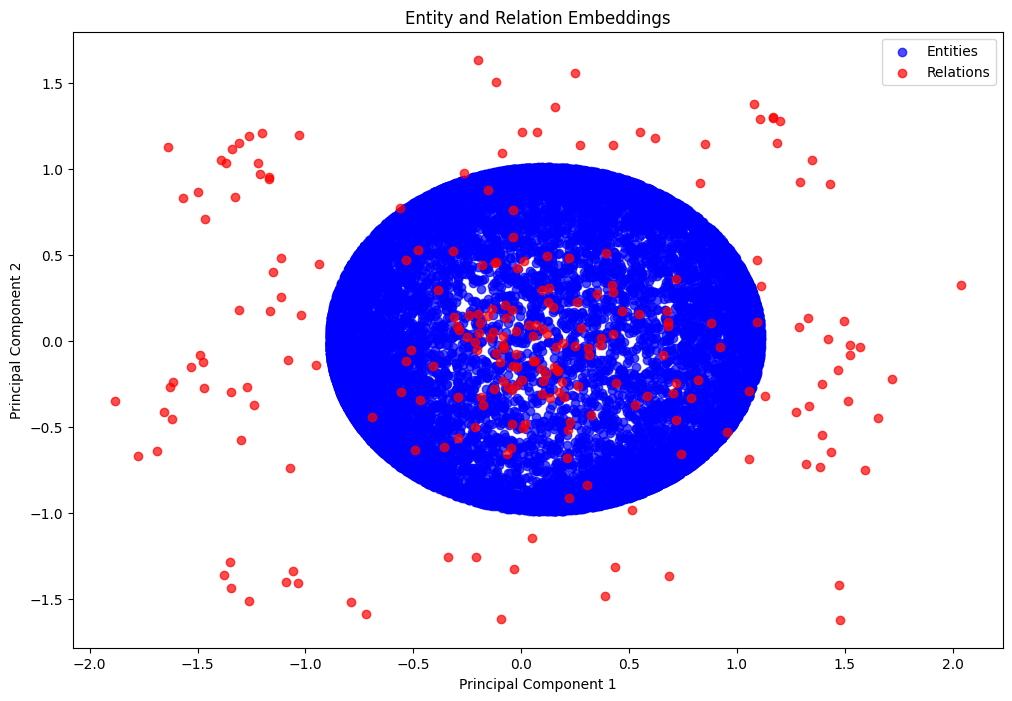

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot entity embeddings
plt.scatter(entity_embeddings_2d[:, 0], entity_embeddings_2d[:, 1], alpha=0.7, label='Entities', color='blue')

# Plot relation embeddings
plt.scatter(relation_embeddings_2d[:, 0], relation_embeddings_2d[:, 1], alpha=0.7, label='Relations', color='red')

plt.title('Entity and Relation Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [6]:
# generate vocabulary
entities = pd.concat(
    [train_df["head"], test_df["head"], val_df["head"], train_df["tail"], test_df["tail"], val_df["tail"]], axis=0)
entities = sorted(list(set(entities)))
print(f"len(entities): {len(entities)}")
relations = pd.concat([train_df["relation"], test_df["relation"], val_df["relation"]])
relations = sorted(list(set(relations)))

print(f"len(relation): {len(relations)}")

id2word = entities + relations
word2id = {word: i for i, word in enumerate(id2word)}

len(entities): 14541
len(relation): 237


In [7]:
# initalize embedding layer

def relation_data_loader(df):
    """
    takes dataframe
    returns: one positive sample(triple) and one negative sample
    """
    df = shuffle(df)
    for i, row in df.iterrows():
        positive_example = [word2id[item] for item in row]
        # randomly sample negative example by replacing head or tail with random entity
        #   with probability 0.5
        if np.random.rand() > 0.5:
            negative_example = [word2id[item] for item in row]
            negative_example[0] = word2id[np.random.choice(entities)]
        else:
            negative_example = [word2id[item] for item in row]
            negative_example[2] = word2id[np.random.choice(entities)]
        yield positive_example, negative_example


def distance_function(t1, t2):
    # implement L1 norm as distance function
    return torch.sum(torch.abs(t1 - t2), dim=-1)


# validation code
def test_accuracy(val_df):
    total = val_df.shape[0]
    correct = 0
    for i, (positive_sample, *_) in tqdm(enumerate(relation_data_loader(val_df)), total=val_df.shape[0]):
        head, relation, actual_entity = positive_sample
        entity_relation_vector = embed_layer(to_device(torch.LongTensor([head, relation]), device))
        # print(entity_relation_vector.shape)
        pred_vector = entity_relation_vector[0] + entity_relation_vector[1]
        # print(pred_vector.shape)
        closest_entity = torch.argmin(distance_function(pred_vector, embed_layer.weight.data), dim=-1)
        # print(f"closest_entity: {closest_entity}")
        if closest_entity == actual_entity:
            correct += 1
    return correct / total



## Using Stochastic gradient

In [8]:

# hyper parameters
# k = 50, λ = 0.01, γ = 1, and d = L1 on FB15k;
embedding_dim = 50
lr = 0.01
gamma = 1
epoch = 1000

# define layer
embed_layer = nn.Embedding(len(id2word), embedding_dim)

# input = torch.LongTensor([[0, 2, 0, 5]])
# embed_layer(input)


for e in range(epoch):
    for i, (positive_sample, negative_sample) in tqdm(enumerate(relation_data_loader(train_df)),
                                                      total=train_df.shape[0]):
        positive_sample = torch.LongTensor(positive_sample)
        negative_sample = torch.LongTensor(negative_sample)
        positive_input = embed_layer(positive_sample)
        negative_input = embed_layer(negative_sample)
        # calculate distance
        positive_distance = distance_function(positive_input[0] + positive_input[1], positive_input[2])
        negative_distance = distance_function(negative_input[0] + negative_input[1], negative_input[2])
        # calculate loss
        loss = gamma + positive_distance - negative_distance
        # backpropagation
        loss.backward()
        # update weights
        embed_layer.weight.data -= lr * embed_layer.weight.grad.data
    # if e%10==0:
    accuracy = test_accuracy(val_df)
    print(f"accuracy @epoch{e}: {accuracy}")



  0%|          | 0/272115 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:

# hyper parameters
# k = 50, λ = 0.01, γ = 1, and d = L1 on FB15k;
embedding_dim = 50
lr = 0.01
gamma = 1
epoch = 1000

# define layer
embed_layer = nn.Embedding(len(id2word), embedding_dim)

# input = torch.LongTensor([[0, 2, 0, 5]])
# embed_layer(input)


for e in range(epoch):
    for i, (positive_sample, negative_sample) in tqdm(enumerate(relation_data_loader(train_df)),
                                                      total=train_df.shape[0]):
        positive_sample = torch.LongTensor(positive_sample)
        negative_sample = torch.LongTensor(negative_sample)
        positive_input = embed_layer(positive_sample)
        negative_input = embed_layer(negative_sample)
        # calculate distance
        positive_distance = distance_function(positive_input[0] + positive_input[1], positive_input[2])
        negative_distance = distance_function(negative_input[0] + negative_input[1], negative_input[2])
        # calculate loss
        loss = gamma + positive_distance - negative_distance
        # backpropagation
        loss.backward()
        # update weights
        embed_layer.weight.data -= lr * embed_layer.weight.grad.data
    # if e%10==0:
    accuracy = test_accuracy(val_df)
    print(f"accuracy @epoch{e}: {accuracy}")

  0%|          | 0/272115 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Pytorch neat implementation

### Model definition

In [21]:
# 1. Where is negative sample formed?
# 2. How is loss applied?
# 3. How does bulk processing happens?
# 4. What are the customized hyperparameters 

def data_loader(df, batch_size=1000):
    """
    takes dataframe
    returns: one positive sample(triple) and one negative sample
    """
    df = shuffle(df)
    # yield 3 series of head, relation and tail of batch_size
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        heads = batch_df["head"].apply(lambda x: word2id[x])
        tails = batch_df["tail"].apply(lambda x: word2id[x])
        relations = batch_df["relation"].apply(lambda x: word2id[x])
        yield to_device(torch.tensor(heads.values), device), to_device(torch.tensor(relations.values), device), to_device(torch.tensor(tails.values), device)


class transE(torch.nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim=50, p_norm=1, margin=1):
        super(transE, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.p_norm = p_norm
        self.margin = margin
        self.embedding = torch.nn.Embedding(num_entities+num_relations, embedding_dim)
        self.relation_embedding = torch.nn.Embedding(num_relations, embedding_dim)

    def forward(self, head_idx, relation_idx):
        # head_relation_idx = torch.LongTensor([head, relation])
        # print(f"head_idx.shape:{head_idx.shape}")
        # print(f"tail_idx.shape:{relation_idx.shape}")
        head_vectors = self.embedding(head_idx)
        relation_vectors = self.embedding(relation_idx)
        # print(f"head_vectors.shape: {head_vectors.shape}")
        # print(f"relation_vectors.shape: {relation_vectors.shape}")
        
        # normalize head
        head_vectors = F.normalize(head_vectors, p=self.p_norm, dim=-1)
        return head_vectors + relation_vectors
    
    def loss(self, head_idx, relation_idx, tail_idx):
        
        # calculate loss on positive sample
        # triplet_tensor = torch.LongTensor(triplet)
        positive_prediction = self(head_idx, relation_idx) # head, relation
        # print(f"positive_prediction.shape:{positive_prediction.shape}")
        actual_tail = self.embedding(tail_idx)
        # print(f"actual_tail.shape:{actual_tail.shape}")
        pos_score = -(positive_prediction - actual_tail).norm(p=self.p_norm, dim=-1)
        # print(f"pos_score.shape: {pos_score.shape}")
        # corrupt the triplet by replacing either head or tail but not both with probability 0.5
        # create mask where head is going to be replaced
        mask = to_device(torch.rand(head_idx.shape) > 0.5, device)
        # create negative sample
        corrupt_head_idx = head_idx.clone()
        corrupt_tail_idx = tail_idx.clone()
        corrupt_head_idx[mask] = to_device(torch.randint(0, self.num_entities, corrupt_head_idx[mask].shape), device)
        corrupt_tail_idx[~mask] = to_device(torch.randint(0, self.num_entities, corrupt_tail_idx[~mask].shape), device)
        # calculate loss on negative sample
        corrupt_prediction = self(corrupt_head_idx, relation_idx)
        corrupt_tail = self.embedding(corrupt_tail_idx)
        neg_score = -(corrupt_prediction - corrupt_tail).norm(p=self.p_norm, dim=-1)
        # print(f"neg_score.shape: {neg_score.shape}")
        
        return F.margin_ranking_loss(
            pos_score,
            neg_score,
            target=torch.ones_like(pos_score),
            margin=self.margin,
        )

        # return torch.max(positive_score - corrupt_score + 1, torch.zeros(1))
        

### Training

In [ ]:
# define hyperparameters
num_entities= len(entities)
num_relations = len(relations)
embedding_dim=50
lr=0.01
epoch = 1000
p_norm=1
margin=1
batch_size=1000

# define model
model = transE(num_entities, num_relations, embedding_dim, p_norm=p_norm, margin=margin)

model = to_device(model, device)
# define optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)


def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in data_loader(train_df, batch_size=batch_size):
        # print(head_index, rel_type, tail_index)
        # break
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        # print(loss)
        # break
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples


for epoch_i in tqdm(range(epoch)):
    mean_loss = train()
    if epoch_i%100 ==0:
        print(f"mean_loss@{epoch_i}: {mean_loss}")
    



  0%|          | 0/1000 [00:00<?, ?it/s]

mean_loss@0: 1.3334290520658112
mean_loss@100: 0.19721234549278657


In [ ]:
# save model
torch.save(model.state_dict(), f"/kaggle/working//transE_model.pth")

### Evaluation

In [ ]:
# load model
saved_model = transE(num_entities, num_relations, embedding_dim, p_norm=p_norm, margin=margin)
saved_model = to_device(saved_model, device)
saved_model.load_state_dict(torch.load(f"/kaggle/working/transE_model.pth"))

# inference related code
def test_accuracy(val_df):
    model.eval()
    total = val_df.shape[0]
    correct = 0
    for head_index, rel_type, tail_index in data_loader(val_df, batch_size=batch_size):
        head_vectors = saved_model.embedding(head_index)
        relation_vectors = saved_model.embedding(rel_type)
        pred_vectors = head_vectors + relation_vectors
        closest_entity = torch.argmin((pred_vectors.unsqueeze(1) - model.embedding.weight.data).norm(p=1, dim=-1), dim=-1)
        correct += (closest_entity == tail_index).sum().item()
    return correct / total

def test_hits(val_df, k=10):
    model.eval()
    total = val_df.shape[0]
    correct = 0
    for head_index, rel_type, tail_index in data_loader(val_df, batch_size=batch_size):
        head_vectors = saved_model.embedding(head_index)
        relation_vectors = saved_model.embedding(rel_type)
        pred_vectors = head_vectors + relation_vectors
        closest_entities = (pred_vectors.unsqueeze(1) - model.embedding.weight.data).norm(p=1, dim=-1).argsort(dim=-1)[:,:k]
        correct += (closest_entities == tail_index.unsqueeze(1)).sum().sum().item()
    return correct / total

    
# accuracy
val_accuracy = test_accuracy(val_df)
print(f"val_accuracy:{val_accuracy}")
test_accuracy = test_accuracy(test_df)
print(f"test_accuracy:{test_accuracy}")


# hits
test_hit_at_10  = test_hits(test_df, k=1)
print(f"Hit@1:{test_hit_at_10}")
test_hit_at_20  = test_hits(test_df, k=3)
print(f"Hit@3:{test_hit_at_20}")
test_hit_at_30  = test_hits(test_df, k=10)
print(f"Hit@10:{test_hit_at_30}")


# References
1. [Translating Embeddings for Modeling
Multi-relational Data(Paper)](https://papers.nips.cc/paper/2013/file/1cecc7a77928ca8133fa24680a88d2f9-Paper.pdf)
2. [Link prediction - papers with code](https://paperswithcode.com/task/link-prediction)
3. [Link prediction - Wikipedia](https://en.wikipedia.org/wiki/Link_prediction)
4. [MARGIN RANKING LOSS - Pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.MarginRankingLoss.html)
5. [Understanding Ranking Loss, Contrastive Loss, Margin Loss, Triplet Loss, Hinge Loss and all those confusing names](https://gombru.github.io/2019/04/03/ranking_loss/)
6. [pytorch geometric - TransE](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.kge.TransE.html#torch_geometric.nn.kge.TransE)